In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
image = cv2.imread("/home/guru/Desktop/ComputerVision/Assignment1/IpythonNotebooks/checkerboard.png",0)

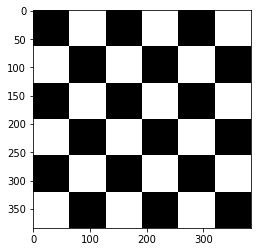

In [5]:
plt.imshow(image, cmap = "gray")

In [6]:
image.shape

(384, 384)

In [49]:
def findCorners(image, window_size, ksize, k, threshold) :
    
    """
    Finds the corners in the image using window of all ones.

    Parameters
    ----------
    image : (N,M) ndarray
        Input image
    window_size : Integer
        It is the size of neighbourhood considered for corner detection
    ksize : Integer 
        Aperture parameter of Sobel derivative used.
    k : Float
        Harris detector free parameter in the equation.
    threshold : Float
        Threshold used to classify a pixel as corner
    
    Returns
    -------
    
    corner_list : List
        List containing the co ordinates of all the corners
    
    corner_image : (N,M) ndarray
        Image with corners marked
    """  
        
    #Calculating the gradient
    dx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize =  ksize)
    dy = cv2.Sobel(image,cv2.CV_64F,0,1,ksize = ksize)
    
    #List which will have co ordinates of all the corners
    cornerList = []
    
    Ixx = dx**2
    Iyy = dy**2
    Ixy = dx*dy
    
    height, width = image.shape
    
    offset = window_size/2
    
    #Creating a copy of the image to mark the corner pixels
    newImg = image.copy()
    color_img = cv2.cvtColor(newImg, cv2.COLOR_GRAY2RGB)
    
    for i in range(offset, height - offset) :
        for j in range(offset, width - offset) :
            
    #Here the window used is a matrix with all ones, so directly sum can be taken 
            Ix_window = Ixx[j-offset:j+offset+1, i-offset:i+offset+1]
            Iy_window = Iyy[j-offset:j+offset+1, i-offset:i+offset+1]
            Ixy_window = Ixy[j-offset:j+offset+1, i-offset:i+offset+1] 
            
            Sxx = np.sum(Ix_window)
            Syy = np.sum(Iy_window)
            Sxy = np.sum(Ixy_window)
            
    # Find determinant and trace, use to get corner response
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r = det - k*(trace**2)
            
            if( r > threshold ) :
                cornerList.append([i,j,r])
                color_img.itemset((i, j, 0), 255)
                color_img.itemset((i, j, 1), 0)
                color_img.itemset((i, j, 2), 0)
    
    return cornerList,color_img;


In [50]:
corners,corner_image = findCorners(image, 5,5, 0.04, 150000)

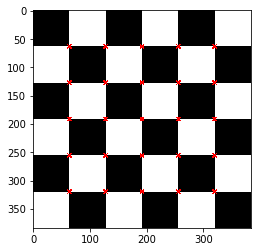

In [51]:
plt.imshow(corner_image)

In [52]:
def gaussian_kernel_2D(ksize, s):
    offset = int(ksize / 2)
    res = np.zeros((ksize, ksize))
    for i in range(-offset, offset + 1):
        for j in range(-offset, offset + 1):
            res[i + offset][j + offset] = np.exp(-(i ** 2 + j ** 2) / (2 * s ** 2)) / (2 * np.pi * s ** 2)
    res = res / np.sum(res)
    #print(res)
    #print(np.sum(res))
    return res


In [61]:

def findCornersGaussianWindow(image, window_size, ksize, k, threshold, std) :
    """
    Finds the corners in the image using Gaussian window.

    Parameters
    ----------
    image : (N,M) ndarray
        Input image
    window_size : Integer
        It is the size of neighbourhood considered for corner detection
    ksize : Integer 
        Aperture parameter of Sobel derivative used.
    k : Float
        Harris detector free parameter in the equation.
    threshold : Float
        Threshold used to classify a pixel as corner
    std : Int
        Standard deviation used by Gaussian Kernel
    
    Returns
    -------
    
    corner_list : List
        List containing the co ordinates of all the corners
    
    corner_image : (N,M) ndarray
        Image with corners marked
    """  
    
    #Calculating the gradient
    dx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize = ksize)
    dy = cv2.Sobel(image,cv2.CV_64F,0,1,ksize = ksize)
    
    #List which will have co ordinates of all the corners
    cornerList = []
    
    Ixx = dx**2
    Iyy = dy**2
    Ixy = dx*dy
    
    height, width = image.shape
    
    offset = window_size/2
    
    #Creating a copy of the image to mark the corner pixels
    newImg = image.copy()
    color_img = cv2.cvtColor(newImg, cv2.COLOR_GRAY2RGB)
    
    
    #Calling function to get 2D gaussian kernel of required size
    Gaussian_weights = gaussian_kernel_2D(window_size,std)
            
    for i in range(offset, height - offset) :
        for j in range(offset, width - offset) :
            
    #Here the window used is a matrix with all ones, so directly sum can be taken 
            Ix_window = Ixx[j-offset:j+offset+1, i-offset:i+offset+1]
            Iy_window = Iyy[j-offset:j+offset+1, i-offset:i+offset+1]
            Ixy_window = Ixy[j-offset:j+offset+1, i-offset:i+offset+1] 
            
           
            Ix_weighted = Ix_window * Gaussian_weights
            Iy_weighted = Iy_window * Gaussian_weights
            Ixy_weighted = Ixy_window * Gaussian_weights
            
            Sxx = np.sum(Ix_weighted)
            Syy = np.sum(Iy_weighted)
            Sxy = np.sum(Ixy_weighted)
            
    # Find determinant and trace, use to get corner response
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r = det - k*(trace**2)
            
           
            
            if( r > threshold ) :
                cornerList.append([i,j,r])
                color_img.itemset((i, j, 0), 255)
                color_img.itemset((i, j, 1), 0)
                color_img.itemset((i, j, 2), 0)
    
    return cornerList,color_img;


In [62]:
corners, cornerImage = findCornersGaussianWindow(image, 5,5,0.04, 100,1)

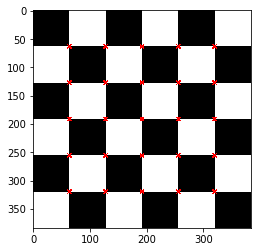

In [63]:
plt.imshow(cornerImage)

In [65]:
len(corners)

1200

In [69]:
c = np.array(corners)

In [70]:
c.shape

(1200, 3)

In [71]:
np.max(c[:,2])

1189866148140507.0